In [1]:
from __future__ import division, print_function
import os
import numpy as np 
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_validate
random_state = 10

In [2]:
train_path = os.path.join(os.getcwd(), 'project','dataset', 'ticdata2000.csv')
X_test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'ticeval2000.txt')
y_test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'tictgts2000.txt')
landsat_train = pd.read_csv(train_path, delimiter = ',',header=0)
X_test = pd.read_csv(X_test_path, delimiter = ' ',header=None)
y_test = pd.read_csv(y_test_path, delimiter = ' ',header=None)

In [160]:
#未处理原始数据
# or_train_path = os.path.join(os.getcwd(), 'project','dataset', 'ticdata2000_orig.csv')
# val_path = os.path.join(os.getcwd(), 'project', 'dataset', 'ticeval2000.txt')
# test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'tictgts2000.txt')
# landsat_train_original = pd.read_csv(or_train_path, delimiter = ',',header=0)
# print(landsat_train_original.shape)
# X_test = pd.read_csv(val_path, delimiter = ' ',header=None)
# y_test = pd.read_csv(test_path, delimiter = ' ',header=None)

(5822, 86)


In [3]:
sample_num = landsat_train.shape[0]
feature_num = landsat_train.shape[1]-1
print("There are {} entries and {} columns in the landsat_train DataFrame"\
      .format(sample_num, feature_num))
if(landsat_train[landsat_train.isnull().values==True].empty):
    print('There is no missing data.')

There are 5822 entries and 52 columns in the landsat_train DataFrame
There is no missing data.


In [19]:
from scipy.stats import skew, kurtosis
print('Skewness:\n{}'.format(skew(landsat_train)[:-1])) # Get rid of label column 
print('Kurtosis:\n{}'.format(kurtosis(landsat_train)[:-1])) # Get rid of label column

Skewness:
[-4.34958330e-01  7.41752040e+00  1.83426611e-01  4.71853977e-01
 -3.31443838e-01  2.23751160e+00  7.45112873e-02  9.02081380e-01
 -1.31279444e-01 -7.18942993e-01  1.31628589e+00  6.93173037e-01
  9.70078786e-01  1.79757478e-01  1.77080171e-01  1.36290138e+00
  1.88413147e-01 -5.43109321e-02  1.17377376e+00  2.84527031e+00
  2.82644798e+00  6.55941348e-01  6.78517842e-01  6.69907076e-01
  1.63742598e+00  1.11242984e+00  3.85310855e-01  1.93031190e-01
  1.41794845e+00  1.51062643e-01 -1.58195886e-01 -2.36823902e-01
  7.74004724e-01  7.28383340e-01 -6.86865061e-01  6.77840076e-01
  5.97292293e-01  1.80374176e-01  6.64176904e-01  1.90897235e+00
  4.20913610e+00  8.16262510e-01  2.20453971e-01  4.82741661e-01
  1.02736578e+01  6.99432193e+00 -1.30813495e-02  1.09949909e+01
  5.12807221e+00  2.69199170e+01  1.17307214e+01  6.82434404e+00
  1.92236433e+01  3.70471368e+00  4.88184632e+00  1.86267626e+01
  1.30380641e+01  1.59974645e+01  3.92889658e-01  6.06282320e+01
  1.59152919e+0

Feature Distribution

In [4]:
feature86_zero = sum(landsat_train["CARAVAN"]==0)
print('There are {} zeros in home policies feature, account for {:.2f}% of samples'.format(feature86_zero, 100*feature86_zero/5822))

There are 5474 zeros in home policies feature, account for 94.02% of samples


In [5]:
#landsat_train["MOSTYPE"]
landsat_train["MOSTYPE"][5821]

33

In [6]:
def transform(feature, class1, class2):
    new = []
    for ii in range(sample_num):
        if(new_data[feature][ii] in class1.values):
            new.append(0)
        elif(new_data[feature][ii] in class2.values):
            new.append(1)
        else:
            print('{} Error! {} is not in the list!'.format(ii,new_data["MOSTYPE"][ii]))
    return new
high_risk = Series([8, 9, 12, 13, 23, 25, 36, 2, 3, 4, 5, 15, 27])
low_risk = Series([1,6,7,10,11,14,16,17,18,19,20,21,22,24,26,28,29,30,31,32,33,34,35,37,38,39,40,41])
Liberals = Series([1, 2, 5, 6])
Conservatives = Series([3, 4, 7, 8, 9, 10])

new_data = landsat_train.copy()
new_data["MOSTYPE"] =  Series(transform("MOSTYPE", high_risk, low_risk))
new_data["MOSHOOFD"] = Series(transform("MOSHOOFD", Liberals, Conservatives))
X_train_full = new_data.iloc[:,:-1].copy()
y_train_full = new_data.iloc[:,-1].copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.33, random_state=random_state)


In [10]:
# X_train_full = landsat_train_original.iloc[:,:-1].copy()
# y_train_full = landsat_train_original.iloc[:,-1].copy()
# print(X_train_full.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
#                                                    test_size=0.33, random_state=random_state)

(5822, 52)


In [7]:
#需要标准化部分
norm_train = X_train.iloc[:, 30:52].copy()
norm_val = X_val.iloc[:, 30:52].copy()
print(X_train.iloc[:, 0:30].shape)

(3900, 30)


In [8]:
norm_train.shape

(3900, 22)

In [9]:
#normalize part data
from sklearn.preprocessing import StandardScaler
normal_train = norm_train.values
normal_val = norm_val.values
sc = StandardScaler().fit(normal_train)
norm_train_sc = sc.transform(normal_train)
norm_val_sc = sc.transform(normal_val)
X_train_sc = np.zeros((X_train.shape[0],X_train.shape[1]))
X_val_sc = np.zeros((X_val.shape[0],X_val.shape[1]))
X_train_sc[:,:30]= X_train.iloc[:,:30]
X_train_sc[:,30:52] = norm_train_sc
X_val_sc[:,:30]= X_val.iloc[:,:30]
X_val_sc[:,30:52] = norm_val_sc
X_train_sc
#print(sc.mean_)
#print(X_train_sc,'\n', y_train,'\n', X_val_sc,'\n', y_val)

array([[ 1.        ,  2.        ,  3.        , ..., -0.0568255 ,
        -0.10729866,  0.74361882],
       [ 1.        ,  1.        ,  3.        , ..., -0.0568255 ,
        -0.10729866, -0.23628998],
       [ 1.        ,  1.        ,  4.        , ..., -0.0568255 ,
        -0.10729866,  2.91947933],
       ...,
       [ 0.        ,  1.        ,  3.        , ..., -0.0568255 ,
        -0.10729866, -0.9410013 ],
       [ 0.        ,  1.        ,  3.        , ..., -0.0568255 ,
        -0.10729866, -0.73781811],
       [ 1.        ,  1.        ,  3.        , ..., -0.0568255 ,
        -0.10729866, -0.51063016]])

In [23]:
#centering all data
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_val_minmax =min_max_scaler.fit_transform(X_val)
np.savetxt('all.csv',X_train_minmax,delimiter=',')

In [31]:
#centering part data
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(normal_train)
X_val_minmax =min_max_scaler.fit_transform(normal_val)
X_train_m = np.zeros((X_train.shape[0],X_train.shape[1]))
X_val_m = np.zeros((X_val.shape[0],X_val.shape[1]))
X_train_m[:,:30]= X_train.iloc[:,:30]
X_train_m[:,30:52] = X_train_minmax
print(X_train_m[:,:30])
X_val_m[:,:30]= X_val.iloc[:,:30]
print(X_train_m[:,:30])

X_val_m[:,30:52] = X_val_minmax
np.savetxt('part.csv',X_train_m,delimiter=',')

[[1. 2. 3. ... 1. 4. 3.]
 [1. 1. 3. ... 2. 4. 3.]
 [1. 1. 4. ... 1. 7. 5.]
 ...
 [0. 1. 3. ... 4. 3. 4.]
 [0. 1. 3. ... 3. 3. 4.]
 [1. 1. 3. ... 4. 4. 3.]]
[[1. 2. 3. ... 1. 4. 3.]
 [1. 1. 3. ... 2. 4. 3.]
 [1. 1. 4. ... 1. 7. 5.]
 ...
 [0. 1. 3. ... 4. 3. 4.]
 [0. 1. 3. ... 3. 3. 4.]
 [1. 1. 3. ... 4. 4. 3.]]


In [45]:
X_train_final = X_train_sc
X_val_final = X_val_sc

In [12]:
np.savetxt('train.csv',X_train_final,delimiter=',')

In [44]:
np.max(X_train_final)

61.741873164540365

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train_final,y_train)

In [47]:
from sklearn.metrics import accuracy_score
# By using the predict() method and accuracy_score metric
gnb_prediction = gnb.predict(X_val_final)
gnb_accuracy = accuracy_score(y_val, gnb_prediction) # The accuracy_score() function takes as inputs
                                                 # the true labels and the predicted ones

# By using the score() method
gnb_accuracy_alt = gnb.score(X_val_final, y_val) # The score() method takes as inputs 
                                              # the test input features and the associated (true) labels

# Print results
print("GNB classification accuracy on validation set (by using the accuracy_score() function): {:.3f}"
      .format(gnb_accuracy))
print("GNB classification accuracy on validation set (by using the model's score() method): {:.3f}"
      .format(gnb_accuracy_alt))

GNB classification accuracy on validation set (by using the accuracy_score() function): 0.107
GNB classification accuracy on validation set (by using the model's score() method): 0.107


In [48]:
from sklearn.dummy import DummyClassifier
# Your code goes here

# most_frequent strategy
dcl_mf = DummyClassifier(strategy='most_frequent')
dcl_mf.fit(X_train_final, y_train) # Clf user guide for alternative strategy options
y_most_frequent = dcl_mf.predict(X_val_final)

# uniformly random prediction strategy
# Set random_state parameter to ensure reproducibility
dcl_rnd = DummyClassifier(strategy='uniform', random_state=10).fit(X_train_final, y_train) 
y_random = dcl_rnd.predict(X_val_final)

print("Baseline classification accuracy on validation set (most frequent class): {:.3f}".
      format(accuracy_score(y_val, y_most_frequent)))
print("Baseline classification accuracy on validation set (random prediction): {:.3f}".
      format(accuracy_score(y_val, y_random)))

Baseline classification accuracy on validation set (most frequent class): 0.939
Baseline classification accuracy on validation set (random prediction): 0.517


Confusion matrix
[[  91 1714]
 [   3  114]]
91 1714 3 114


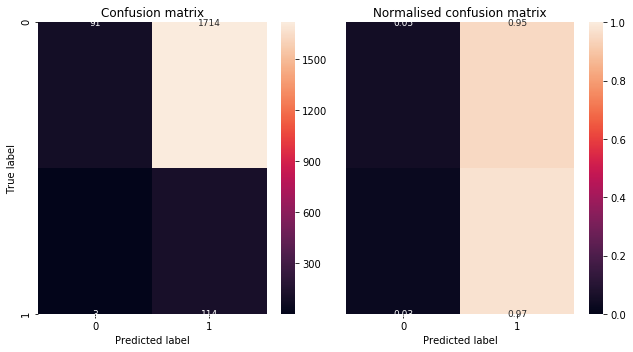

In [49]:
from sklearn.metrics import confusion_matrix
# Your code goes here
cm = confusion_matrix(y_val, gnb_prediction)
print('Confusion matrix\n{}'.format(cm))
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax, 
                    annot=True, annot_kws={"fontsize":9}, fmt=fmt)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False, \
                      classes=gnb.classes_) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, \
                      classes=gnb.classes_, title='Normalised confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
# Your code goes here
pred_proba_dummy = dcl_mf.predict_proba(X_val_final)
pred_proba_gnb = gnb.predict_proba(X_val_final)
print("Log-loss scores:\nDummy classifier {}\nGaussian Naive Bayes classifier {}".
      format(log_loss(y_val, pred_proba_dummy), log_loss(y_val, pred_proba_gnb)))
names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net (Multi-layer perceptron)",
         "Naive Bayes", "LDA", "QDA"]
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=9),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(random_state=random_state),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
     QuadraticDiscriminantAnalysis()]
ca_score = {} # Classification accuracy
ce_score = {} # Cross-entropy
pre = {}
for name, clf in zip(names, classifiers):
    clf.fit(X_train_final, y_train)
    pre[name] = clf.predict(X_val_final)
    ca_score[name] = clf.score(X_val_final, y_val)
    ce_score[name] = log_loss(y_val, clf.predict_proba(X_val_final))
print('Classification performance on validation set:')
for clf in names:
    print ("{}, accuracy: {:.3f}, log-loss: {:.3f}".format(clf, ca_score[clf], ce_score[clf]))
    cm = confusion_matrix(y_val, pre[clf])
    print('Confusion matrix\n{}'.format(cm))
#     fig = plt.figure(figsize=(9,5))
#     ax1 = fig.add_subplot(121)
#     plot_confusion_matrix(cm, normalize=False, \
#                           classes=gnb.classes_) # un-normalized
#     ax2 = fig.add_subplot(122)
#     plot_confusion_matrix(cm, normalize=True, \
#                           classes=gnb.classes_, title='Normalised confusion matrix') # normalized
#     ax2.get_yaxis().set_visible(False)
#     fig.tight_layout()

Log-loss scores:
Dummy classifier 2.102516565142847
Gaussian Naive Bayes classifier 27.98025678630097


C:\Users\Lynn\Miniconda3\envs\dme\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Lynn\Miniconda3\envs\dme\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classification performance on validation set:
Logistic Regression, accuracy: 0.937, log-loss: 0.217
Confusion matrix
[[1800    5]
 [ 116    1]]
Nearest Neighbors, accuracy: 0.938, log-loss: 0.946
Confusion matrix
[[1802    3]
 [ 116    1]]
Linear SVM, accuracy: 0.939, log-loss: 0.229
Confusion matrix
[[1805    0]
 [ 117    0]]
RBF SVM, accuracy: 0.939, log-loss: 0.229
Confusion matrix
[[1805    0]
 [ 117    0]]
Decision Tree, accuracy: 0.920, log-loss: 1.191
Confusion matrix
[[1759   46]
 [ 107   10]]
Random Forest, accuracy: 0.939, log-loss: 0.219
Confusion matrix
[[1804    1]
 [ 117    0]]
Neural Net (Multi-layer perceptron), accuracy: 0.924, log-loss: 0.371
Confusion matrix
[[1767   38]
 [ 109    8]]
Naive Bayes, accuracy: 0.107, log-loss: 27.980
Confusion matrix
[[  91 1714]
 [   3  114]]
LDA, accuracy: 0.934, log-loss: 0.225
Confusion matrix
[[1793   12]
 [ 115    2]]
QDA, accuracy: 0.102, log-loss: 30.930
Confusion matrix
[[  82 1723]
 [   2  115]]


C:\Users\Lynn\Miniconda3\envs\dme\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


优化部分

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
svc = SVC(kernel='rbf')
parameters = {'C': np.logspace(-3,3,7)}
svc_clf = GridSearchCV(estimator=svc, cv=cv, param_grid=parameters, scoring='accuracy')
svc_clf.fit(X_train_final, y_train)
print("Best setting of C parameter for SVC with RBF kernel: {}".format(svc_clf.best_params_["C"]))
print("Best cross-validated score: {:.3f}".
      format(svc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(svc_clf.score(X_val_final,y_val)))

Best setting of C parameter for SVC with RBF kernel: 0.001
Best cross-validated score: 0.941
Classification accuracy on validation set: 0.939


In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
svc = SVC(kernel='rbf')
parameters = {'C': np.logspace(-3,3,7), 'gamma' : np.logspace(-4, 1, 6)}
svc_clf = GridSearchCV(estimator=svc, cv=cv, param_grid=parameters, scoring='accuracy')
svc_clf.fit(X_train_final, y_train)
print("Best parameters for SVC with RBF kernel, C: {}, gamma: {}".
      format(svc_clf.best_params_["C"], svc_clf.best_params_["gamma"]))
print("Best cross-validated score: {}".
      format(svc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(svc_clf.score(X_val_final,y_val)))

Best parameters for SVC with RBF kernel, C: 0.001, gamma: 0.0001
Best cross-validated score: 0.9407692307692308
Classification accuracy on validation set: 0.939


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

# MLP with variable hidden layer size and alpha, score: log-loss
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
parameters = {'hidden_layer_sizes' : [(10,), (100,), (1000,)], 'alpha' : np.logspace(-8,0,9)}
mlp_clf = GridSearchCV(mlp, param_grid=parameters, scoring='neg_log_loss')
mlp_clf.fit(X_train_final, y_train)
print("Best parameters for MLP classifier: hidden layer size: {}, alpha: {}, best cross-validated score: {:.3f}".
      format(mlp_clf.best_params_["hidden_layer_sizes"], mlp_clf.best_params_["alpha"], mlp_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_clf.predict(X_val_final))))

In [ ]:
# MLP with variable hidden layer size and alpha, score: accuracy
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
parameters = {'hidden_layer_sizes' : [(10,), (100,), (1000,)], 'alpha' : np.logspace(-8,0,9)}
mlp_clf = GridSearchCV(mlp, param_grid=parameters, scoring='accuracy')
mlp_clf.fit(X_train_final, y_train)
print("Best parameters for MLP classifier: hidden layer size: {}, alpha: {}, best cross-validated score: {:.3f}".
      format(mlp_clf.best_params_["hidden_layer_sizes"], mlp_clf.best_params_["alpha"], mlp_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_clf.predict(X_val_sc))))

In [ ]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=3, shuffle=True, random_state=random_state) # We want to use 3-fold CV to compute the loss in each iteration
svc_clf = SVC(kernel='rbf') # Constructor without defining hyper-parameters just yet

def objective_svc(params): # Here we define the metric we want to minimise
    C, gamma = params
    svc_clf.set_params(C=C, 
                      gamma=gamma) # Set the parameters of the clf
    
    return -np.mean(cross_val_score(svc_clf, X_train_final, y_train, cv=cv, n_jobs=-1,
                                    scoring="accuracy")) # We want to maximise average accuracy, i.e. minimise minus average accuracy

# Search space for the two parameters
space  = [(10**-3, 10**3, "uniform"), # C
          (10**-4, 10**1, "uniform")] # gamma

# Initial values (optional)
x0 = [1, 10**-2]

In [ ]:
from skopt import gp_minimize
res_gp = gp_minimize(func=objective_svc, dimensions=space, x0=x0, 
                     n_calls=25, random_state=random_state, n_random_starts=5, kappa=1.9)
print("Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun))
print("Best parameters with Bayesian optimisation:\nC: {}\ngamma: {}"
      .format(res_gp.x[0],res_gp.x[1]))

In [ ]:
from skopt.plots import plot_convergence
plt.figure(figsize=(5,2))
plot_convergence(res_gp)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(res_gp.func_vals)
plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
plt.ylabel(r'$f(x)$')
plt.xlabel('Number of calls $n$')
plt.xlim([0, len(res_gp.func_vals)])
plt.show()

In [ ]:
svc_opt = SVC(kernel='rbf',
             C=res_gp.x[0],
             gamma=res_gp.x[1]).fit(X_train_sc,y_train)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, svc_opt.predict(X_val_sc))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, svc_opt.predict(X_test_sc))))

Not in use

In [246]:
def get_key (dict, value):
    return [k for k, v in dict.items() if v == value]

In [92]:
def newfeature(features):
    MG_prob = []
    MG_value = []
    for sample in range(sample_num):
        MG_dic = defaultdict(dict)
        for feature in features:
            MG_dic[feature] = landsat_train[feature][sample]
        pro = max(MG_dic.values())
        if(len(get_key(MG_dic, pro))==1):
            MG_NEW = get_key(MG_dic, pro)[0]
        elif(len(get_key(MG_dic, pro))==2):
            n = random.random()
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=0.5):
                MG_NEW = get_key(MG_dic, pro)[1]
        elif(len(get_key(MG_dic, pro))==3):
            n = random.uniform(0,3)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
        elif(len(get_key(MG_dic, pro))==4):
            n = random.uniform(0,4)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
            elif(n>=3):
                MG_NEW = get_key(MG_dic, pro)[3]
        elif(len(get_key(MG_dic, pro))==5):
            n = random.uniform(0,5)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
            elif(n>=3):
                MG_NEW = get_key(MG_dic, pro)[3]
            elif(n>=4):
                MG_NEW = get_key(MG_dic, pro)[4]
        for feature in range(len(features)):
            if (MG_NEW == features[feature]):
                MG_value.append(feature)
        MG_prob.append(pro)
    return MG_NEW,MG_value
#newfeature(["MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO"])

In [88]:
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L0_Labels.csv')
L0_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L1_Labels.csv')
L1_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L2_Labels.csv')
L2_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L3_Labels.csv')
L3_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L4_Labels.csv')
L4_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
L2_Labels

,L2_Labels
1,Successful hedonists
2,Driven Growers
3,Average Family
4,Career Loners
5,Living well
6,Cruising Seniors
7,Retired and Religeous
8,Family with grown ups
9,Conservative families
10,Farmers


In [48]:
L0_labels_dict = L0_Labels.to_dict()["L0_Labels"]
L1_labels_dict = L1_Labels.to_dict()["L1_Labels"]
L2_labels_dict = L2_Labels.to_dict()["L2_Labels"]
L3_labels_dict = L3_Labels.to_dict()["L3_Labels"]
L4_labels_dict = L4_Labels.to_dict()["L4_Labels"]

In [92]:
Counter(landsat_train["MGEMLEEF"])

Counter({2: 1452, 3: 3000, 1: 74, 4: 1073, 5: 193, 6: 30})

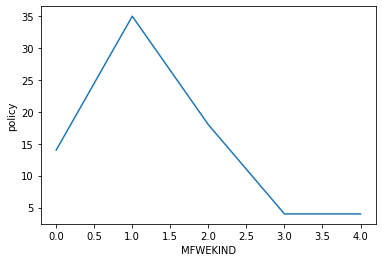

In [199]:
dic = defaultdict(dict)
age = []
policy = []
buyer = []

for ii in range(sample_num):
    if (landsat_train["MRELGE"][ii] == 1):
        buyer.append(ii)
        if (dic.get(landsat_train[feature][ii])):
            dic[landsat_train[feature][ii]] += 1 
        else :
            dic[landsat_train[feature][ii]] = 1

for i in sorted (dic) : 
    age.append(i)
    policy.append(dic[i])
plt.xlabel(str(feature))
plt.ylabel("policy")
plt.plot(age, policy)
plt.savefig('./{}.png'.format(str(feature)))

In [153]:
feature = "APLEZIER"

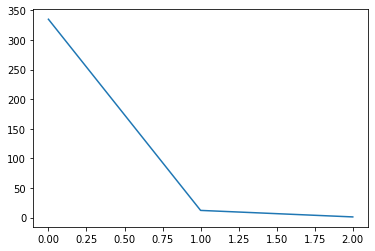

In [154]:
dic = defaultdict(dict)
age = []
policy = []
buyer = []

for ii in range(sample_num):
    if (landsat_train["CARAVAN"][ii] == 1):
        buyer.append(ii)
        if (dic.get(landsat_train[feature][ii])):
            dic[landsat_train[feature][ii]] += 1 
        else :
            dic[landsat_train[feature][ii]] = 1

for i in sorted (dic) : 
    age.append(i)
    policy.append(dic[i])

plt.plot(age, policy)

In [94]:
Counter(landsat_train["MINKGEM"])

Counter({4: 1854,
         5: 733,
         3: 1932,
         6: 355,
         2: 651,
         8: 70,
         1: 49,
         7: 131,
         9: 22,
         0: 25})